## **Classifying income group: either <=50K or >50K**

**Table of contents**    
- Libraries    
- Reading and cleaning the data    
  - Merging the data    
  - Inspecting object class columns' frequency tables    
  - Cleaning object columns to avoid having near-zero-variance variables in the model    
  - Frequency tables of cleaned object variables    
  - NaN values    
  - Removing redundant variables    
- Modeling    
  - Logistic regression model    
  - Prediction    
  - Confusion matrix    
  - Classification report    
  - No-Information rate (the share of the most frequent class in the dependent variable)    
  - Random Forest model    
  - Classification report    
  - Importance plot    
- Conclusion    

## Libraries

In [208]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import classification_report,roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from ucimlrepo import fetch_ucirepo  
from imblearn.over_sampling import RandomOverSampler

## Reading and cleaning the data

In [171]:
# fetch dataset 
adult = fetch_ucirepo(id=2) 
  
# data (as pandas dataframes) 
X = adult.data.features 
y = adult.data.targets 

### Merging the data

In [172]:
df = pd.merge(X,y, left_index=True, right_index=True)

### Inspecting object class columns' frequency tables

In [173]:
df.select_dtypes('object').columns.to_list()

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country',
 'income']

In [174]:
for column in df.select_dtypes('object').columns.to_list():
    print(f'column: {column}\n')
    print(df[column].value_counts())

column: workclass

Private             33906
Self-emp-not-inc     3862
Local-gov            3136
State-gov            1981
?                    1836
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64
column: education

HS-grad         15784
Some-college    10878
Bachelors        8025
Masters          2657
Assoc-voc        2061
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           955
Prof-school       834
9th               756
12th              657
Doctorate         594
5th-6th           509
1st-4th           247
Preschool          83
Name: education, dtype: int64
column: marital-status

Married-civ-spouse       22379
Never-married            16117
Divorced                  6633
Separated                 1530
Widowed                   1518
Married-spouse-absent      628
Married-AF-spouse           37
Name: marital-status, dtype: int64
column: occupation

Prof-specialty      

### Cleaning object columns to avoid having near-zero-variance variables in the model

In [175]:
def fix_income(x):
    x = x.strip().replace('.','')
    return x 

In [176]:
df['income'] = df['income'].apply(fix_income)

In [177]:
df.replace({"?":np.nan},inplace=True)

In [178]:
def fix_workclass(x):
    if x in ["Local-gov","State-gov","Federal-gov"]:
        return "gov"
    else:
        return x

In [179]:
df['workclass'] = df['workclass'].apply(fix_workclass)

In [180]:
df['race'] = df['race'].apply(lambda x: "Other" if x in ["Asian-Pac-Islander","Amer-Indian-Eskimo","Other"] else x)

df['native-country'] = df['native-country'].apply(lambda x: "Europe" if x in ["Germany", "England", "Poland", "Italy", "Portugal",
            "Greece", "France", "Ireland", "Yugoslavia", "Hungary",
            "Scotland", "Holand-Netherlands"] else x)
df['native-country'] = df['native-country'].apply(lambda x: "Other" if x not in ["Europe","United-States"] else x)

df['education'] = df['education'].apply(lambda x: "1-9th" if x in ["1st-4th","5th-6th","7th-8th","9th"] else x)
df['education'] = df['education'].apply(lambda x: "10-12th" if x in ["10th","11th","12th"] else x)
df['education'] = df['education'].apply(lambda x: "Assoc" if x in ["Assoc-acdm","Assoc-voc"] else x)

df['occupation'] = df['occupation'].apply(lambda x: "Other" if x in ["Protective-serv","Priv-house-serv","Armed-Forces"] else x)

df['marital-status'] = df['marital-status'].apply(lambda x: "Married" if x in ["Married-civ-spouse","Married-spouse-absent","Married-AF-spouse","Separated"] else x)
df['marital-status'] = df['marital-status'].apply(lambda x: "Not married" if x in ["Never-married","Divorced","Widowed"] else x) 

In [181]:
for column in df.select_dtypes('object').columns.to_list():
    print(f'column: {column}\n')
    print(df[column].value_counts())

column: workclass

Private             33906
gov                  6549
Self-emp-not-inc     3862
Self-emp-inc         1695
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64
column: education

HS-grad         15784
Some-college    10878
Bachelors        8025
10-12th          3858
Assoc            3662
Masters          2657
1-9th            2467
Prof-school       834
Doctorate         594
Preschool          83
Name: education, dtype: int64
column: marital-status

Married        24574
Not married    24268
Name: marital-status, dtype: int64
column: occupation

Prof-specialty       6172
Craft-repair         6112
Exec-managerial      6086
Adm-clerical         5611
Sales                5504
Other-service        4923
Machine-op-inspct    3022
Transport-moving     2355
Handlers-cleaners    2072
Farming-fishing      1490
Tech-support         1446
Other                1240
Name: occupation, dtype: int64
column: relationship

Husband           19716
Not-in-family   

In [182]:
df = df[~((df["education"]=="Preschool") | (df["workclass"].isin(["Without-pay", "Never-worked"])))]

### Frequency tables of cleaned object variables

In [183]:
for column in df.select_dtypes('object').columns.to_list():
    print(f'column: {column}\n')
    print(df[column].value_counts())

column: workclass

Private             33843
gov                  6544
Self-emp-not-inc     3857
Self-emp-inc         1695
Name: workclass, dtype: int64
column: education

HS-grad         15768
Some-college    10873
Bachelors        8025
10-12th          3853
Assoc            3660
Masters          2657
1-9th            2464
Prof-school       834
Doctorate         594
Name: education, dtype: int64
column: marital-status

Married        24520
Not married    24208
Name: marital-status, dtype: int64
column: occupation

Prof-specialty       6171
Craft-repair         6105
Exec-managerial      6084
Adm-clerical         5605
Sales                5501
Other-service        4899
Machine-op-inspct    3008
Transport-moving     2352
Handlers-cleaners    2065
Farming-fishing      1465
Tech-support         1446
Other                1238
Name: occupation, dtype: int64
column: relationship

Husband           19685
Not-in-family     12544
Own-child          7559
Unmarried          5117
Wife              

### NaN values

In [184]:
df.isna().sum().sort_values(ascending=False)

workclass         2789
occupation        2789
age                  0
fnlwgt               0
education            0
education-num        0
marital-status       0
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country       0
income               0
dtype: int64

In [189]:
df= df.dropna()

In [185]:
cols = df.select_dtypes('object').columns.to_list()

In [186]:
cols.remove("income")

In [187]:
df['sex'].unique()

array(['Male', 'Female'], dtype=object)

In [188]:
cols

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country']

### Removing redundant variables

In [190]:
df = df.drop(["capital-gain","capital-loss","education-num"],axis=1)

In [191]:
df["income"] = np.where(df["income"] == "<=50K",0,1)

In [192]:
df = pd.get_dummies(data=df,columns=cols,drop_first=True)

In [193]:
X = df.drop("income",axis=1)
y = df["income"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=123)
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (36751, 36)
X_test shape: (9188, 36)
y_train shape: (36751,)
y_test shape: (9188,)


## Modeling

### Logistic regression model

In [196]:
mod = sm.Logit(y_train,X_train).fit()
print(mod.summary())

Optimization terminated successfully.
         Current function value: 0.369239
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 income   No. Observations:                36751
Model:                          Logit   Df Residuals:                    36715
Method:                           MLE   Df Model:                           35
Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                  0.3416
Time:                        00:50:12   Log-Likelihood:                -13570.
converged:                       True   LL-Null:                       -20609.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
age                              0.0154      0.001     12.410      0.000

### Prediction

In [198]:
def group(x):
    if x>=0.5:
        return 1
    else:
        return 0

In [200]:
y_test_pred = mod.predict(X_test).apply(group)

### Confusion matrix

In [202]:
print(confusion_matrix(y_true = y_test, y_pred= y_test_pred))

[[6318  587]
 [1046 1237]]


### Classification report

#### Regarding group "0":
* precision = 0.86 implies that among all observations that were classified as "0" by the model, 86% of them were of class "0" in reality
* recall = 0.91 implies that the model correctly classified 91% observations of class "0"
* f1-score is a harmonic average considering both precision and recall
* support = 6905 implies that there are 6905 instances of "0" class

#### Regarding group "1":
* precision = 0.68 implies that among all observations that were classified as "1" by the model, 68% of them were of class "1" in reality
* recall = 0.54 implies that the model correctly classified 54% observations of class "1"
* f1-score is a harmonic average considering both precision and recall
* support = 2283 implies that there are 2283 instances of "1" class

In [204]:
print(classification_report(y_true = y_test, y_pred= y_test_pred))

              precision    recall  f1-score   support

           0       0.86      0.91      0.89      6905
           1       0.68      0.54      0.60      2283

    accuracy                           0.82      9188
   macro avg       0.77      0.73      0.74      9188
weighted avg       0.81      0.82      0.82      9188



In [206]:
y_test.value_counts()

0    6905
1    2283
Name: income, dtype: int64

### No-Information rate (the share of the most frequent class in the dependent variable)

In [207]:
6905/(6905+2283)

0.751523726599913

### Random Forest model

In [250]:
rf_mod = RandomForestClassifier(n_estimators=150,max_depth=10,max_features=10)
rf_mod.fit(X_train,y_train)

RandomForestClassifier(max_depth=10, max_features=10, n_estimators=150)

In [251]:
y_test_pred_rf = rf_mod.predict(X_test)

### Classification report

In [252]:
print(classification_report(y_true=y_test,y_pred=y_test_pred_rf))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      6905
           1       0.72      0.49      0.59      2283

    accuracy                           0.83      9188
   macro avg       0.79      0.72      0.74      9188
weighted avg       0.82      0.83      0.82      9188



### Importance plot

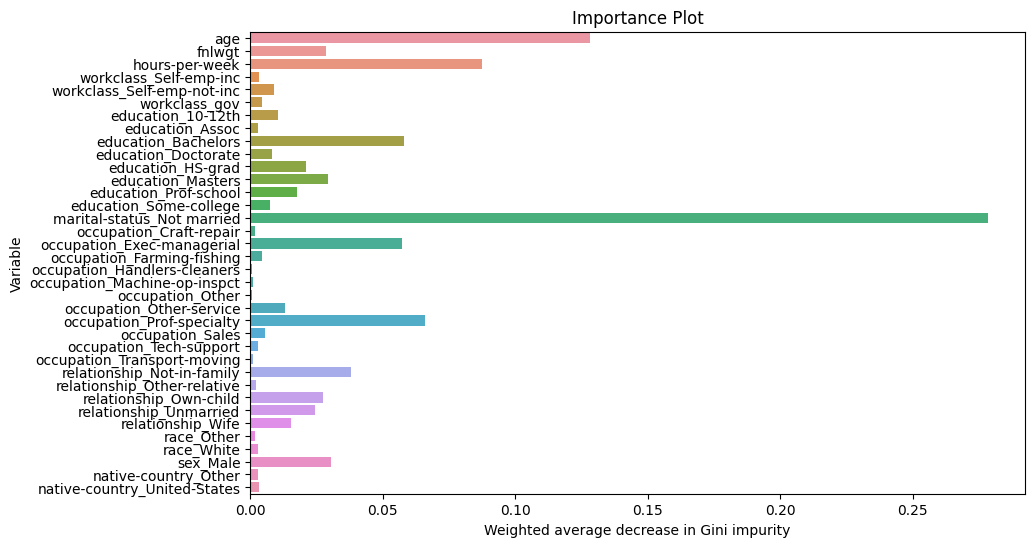

In [256]:
importances = rf_mod.feature_importances_
cols_list = X_train.columns.to_list()
importances_list = list(importances)

plt.figure(figsize=(10,6))
sns.barplot(y=cols_list,x=importances_list)
plt.title('Importance Plot')
plt.ylabel('Variable')
plt.xlabel('Weighted average decrease in Gini impurity')
plt.show()

## Conclusion

### While both logistic regression exhibit similar accuracy scores (0.82 and 0.83), logistic regression model seems better in terms of balancing sensitivity and specificity (0.91,0.54 and 0.94,0.49)